# Impact of Superhost Status

## Import Data and Library

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# reviews.csv will not be used in the analysis due to limited usability
calendar_csv = pd.read_csv('./project_1/calendar.csv')
listings_csv = pd.read_csv('./project_1/listings.csv')

## Project Motivation

For the second research question we have looked at Superhost listings in Seattle. To become an Airbnb 
superhost you have to fill out several criteria over the predefined period of time - details 
[here](https://www.airbnb.com/d/superhost). The Superhost status gives several benefits to the host, such as:

- more visibility
- earning potential
- exclusive rewards
- ...

Being a Superhost is clearly a desirable feature which a lot of hosts would want to have. However, the status 
is not easy to obtain and hold on to as several conditions have to be met. Once obtained it provides a nice 
boost to the host as seen from the perks listed above.  

Several methods of analysis have been incorporated in order to best present the problem at hand. Graphs, 
tables and a simple T-test have been implemented. More details below...

## Data Cleaning and Preperation

Due to the unstructured format in which the raw .csv files are presented a lot of time and effort had to be 
invested in cleaning the data. We are dealing with what appears to be raw production data which requires a lot
of pre-processing in order to prepare it for further analysis. Several methods of data cleaning had to be 
undertaken to get a good grasp on our dataset.

First we have checked for missing values in both datasets and dropped variables with more than 50% of the rows
 missing.

In [4]:
def missing_cols(df):
    """
    The function quantifies the percentage of missing values in each column of the dataframe.
        * df: A pandas dataframe
    :returns: A pandas dataframe
    """
    return pd.DataFrame(df.isnull().mean() * 100, columns=['missing_values'])

miss_calendar = missing_cols(calendar_csv)
miss_listings = missing_cols(listings_csv)

After checking for missing values in both datasets we have decided on the 50% cutoff point. All columns with 
more than half of values missing will de dropped from the dataframe. Looking through the results no columns 
were dropped from **calendar_csv** but four columns had to be dropped from **listings_csv** due to the amount 
of missing values.

In [5]:
# No columns to drop from 'calendar_csv'
print(miss_calendar)

            missing_values
listing_id        0.000000
date              0.000000
available         0.000000
price            32.938998


In [6]:
# Four columns had to be dropped from 'listings_csv' due to amount of missing values
print(miss_listings[miss_listings.missing_values > 0].sort_values(by='missing_values', ascending=False))

                             missing_values
license                          100.000000
square_feet                       97.459403
monthly_price                     60.267156
security_deposit                  51.126244
weekly_price                      47.380828
notes                             42.063908
neighborhood_overview             27.029859
cleaning_fee                      26.977475
transit                           24.463070
host_about                        22.498690
host_acceptance_rate              20.246202
review_scores_accuracy            17.234154
review_scores_checkin             17.234154
review_scores_value               17.181771
review_scores_location            17.155579
review_scores_cleanliness         17.103195
review_scores_communication       17.050812
review_scores_rating              16.946045
last_review                       16.422211
first_review                      16.422211
reviews_per_month                 16.422211
space                           

After dropping the missing columns we have then merged the two datasets using a _'left join'_ on the 
**calendar_csv** to obtain a full time series of bookings and listing information. This way we were got full 
host information for each day along with the daily listing price for each unit.

In [7]:
# remove columns with more than half of the data missing and merge the two databases
def drop_and_join(df1, df2, df1_col: str, df2_col: str):
    """
    The functions checks the two dataframes for missing values and removes the columns where more than half 
    (> 0.5) of values are missing. It then left joins the two dataframes on selected columns.
        * df1: First dataframe to join on
        * df2: Second dataframe which will join on 'df1'
        * df1_col: Column in 'df1' to join by
        * df2_col: Column in 'df2' to join by
    :returns: A joined dataframe.
    """
    df1_miss = missing_cols(df1)
    df2_miss = missing_cols(df2)
    
    df1_clean = df1_miss[df1_miss.missing_values > 50]
    df2_clean = df2_miss[df2_miss.missing_values > 50]
    
    df1_subset = df1.loc[:, ~df1.columns.isin(df1_clean.index)]
    df2_subset = df2.loc[:, ~df2.columns.isin(df2_clean.index)]
    
    return pd.merge(left=df1_subset, right=df2_subset, how='left', left_on=df1_col, right_on=df2_col)

listings_full = drop_and_join(calendar_csv, listings_csv, df1_col='listing_id', df2_col='id')

The next order of business was to clean the data by replacing values with more meaningful descriptors, 
parsing numercial variables and reducing the size of the data frame in order to speed up the calculations.

In [8]:
def clean_data(df):
    """
    Function takes a joined 'df' and cleans it by removing redundant columns, renaming values and generating 
    new columns.
        * df: merged dataframe of 'calendar.csv' and 'listings.csv'
    :returns: A cleaned dataframe.
    """
    # remove URL columns which are redundant
    url_cols = df.filter(like='url')
    df_no_url = df.loc[:, ~df.columns.isin(url_cols.columns)].copy()
    
    # rename 'price' columns
    df_no_url.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)
    
    # replace values with meaningful descriptors
    cols_to_replace = {
        'host_is_superhost': {'t': 'superhost', 'f': 'regular'},
        'available': {'t': 'free', 'f': 'booked'}
    }
    
    for k, v in cols_to_replace.items():
        df_no_url[k].replace(
            to_replace=v,
            inplace=True
        )
    
    # add 'year' and 'month' variables
    df_no_url['year'] = pd.DatetimeIndex(df_no_url['date']).year
    df_no_url['month'] = pd.DatetimeIndex(df_no_url['date']).month
    
    # drop cols with single unique value
    cols_len_one = []
    
    for i in df_no_url.columns:
        if len(df_no_url[i].unique()) == 1:
            cols_len_one.append(i)
    
    df_clean = df_no_url.loc[:, ~df_no_url.columns.isin(cols_len_one)].copy()
    
    # reformat price columns into a float dtype
    for col in ['price', 'weekly_price', 'cleaning_fee', 'extra_people']:
        df_clean[col] = df_clean[col].str.replace(',', '').str.replace('$', '').astype(float)
    
    # reformat 'host_response_rate'
    df_clean.host_response_rate = df_clean.host_response_rate.str.replace('%', '').astype(float) / 100
    
    # further remove redundant columns
    cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit',
                    'host_name', 'host_location', 'host_about', 'street', 'neighborhood_overview', 'zipcode',
                    'smart_location', 'latitude', 'longitude', 'price_y', 'calendar_updated', 'neighbourhood',
                    'host_acceptance_rate', 'state', 'city', 'is_location_exact']
    
    return df_clean.loc[:, ~df_clean.columns.isin(cols_to_drop)]

seattle_df_clean = clean_data(listings_full)

<ipython-input-8-10cb872205ed>:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_clean[col] = df_clean[col].str.replace(',', '').str.replace('$', '').astype(float)


Next, we have to drop missing rows from the  _**price**_ column.

In [9]:
# Remove NA from predictive variable
price = seattle_df_clean.iloc[:, [3, 1, 4]].dropna(axis=0)

value_listings_db = pd.merge(left=seattle_df_clean, right=price, how='inner', on=['date', 'id'])
value_listings_db.drop(axis=1, labels='price_y', inplace=True)
value_listings_db.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)

## Data Analysis

### Plotting and Data Aggregation

Following the data cleaning process we are ready for further analysis. First we introduce some graphs and 
pivot tables and observe potential differences between `Regular` and `Superhosts`. From the table below we can 
see that almost 80% of hosts in Seattle are regular and the rest are Superhosts.

In [10]:
hosts = value_listings_db.pivot_table(values='id', index='host_is_superhost', aggfunc=pd.Series.nunique)
hosts['host_pct']=round((hosts.id/sum(hosts.id))*100,2)
pd.DataFrame(hosts)

,id,host_pct
host_is_superhost,,
regular,2959,79.52
superhost,762,20.48


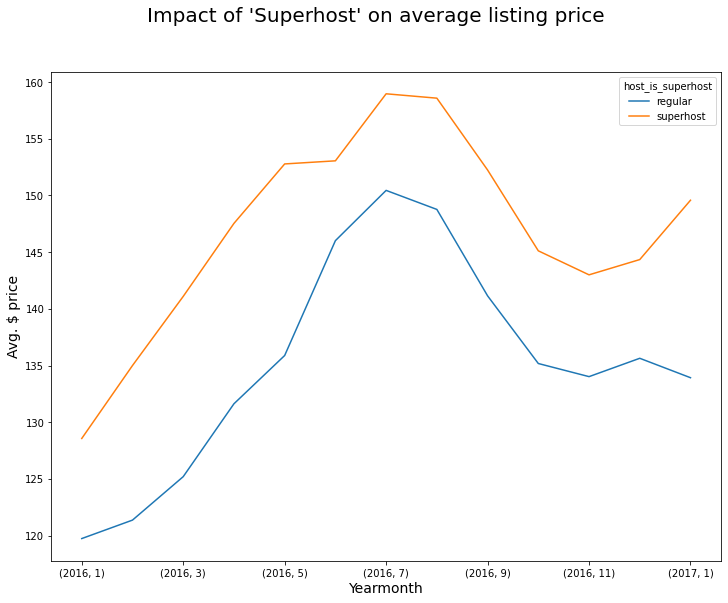

In [11]:
# Superhost price diff
f, ax = plt.subplots(1, 1, figsize = (12, 9))
value_listings_db.pivot_table(index=['year', 'month'], values='price', columns='host_is_superhost',
                              aggfunc=np.mean).plot(ax=ax)
plt.suptitle('Impact of \'Superhost\' on average listing price', size=20)
plt.xlabel("Yearmonth", size=14)
plt.ylabel("Avg. $ price", size=14)
plt.show()

Looking at the _price_ variable we can see that the average price between **Regular** and **Superhosts** 
differs by about 11 USD on average. On a yearly basis this would add up to ~$4000 which is not a negligible 
amount.

In [12]:
value_listings_db.pivot_table(values='price', index='host_is_superhost', aggfunc=[np.mean, np.min, np.max])

,mean,amin,amax
,price,price,price
host_is_superhost,,,
regular,135.711346,10.0,1650.0
superhost,146.851296,29.0,1199.0


Next, we move on to check if any other variables display the difference between regular and superhosts. We 
can see by observing  the most common `proprerty_type` values that there are significant differences in 
average rental prices for **houses**. **Apartments** show some difference in the first half of the year 2016, 
but it fades as we move through the second half of the year.

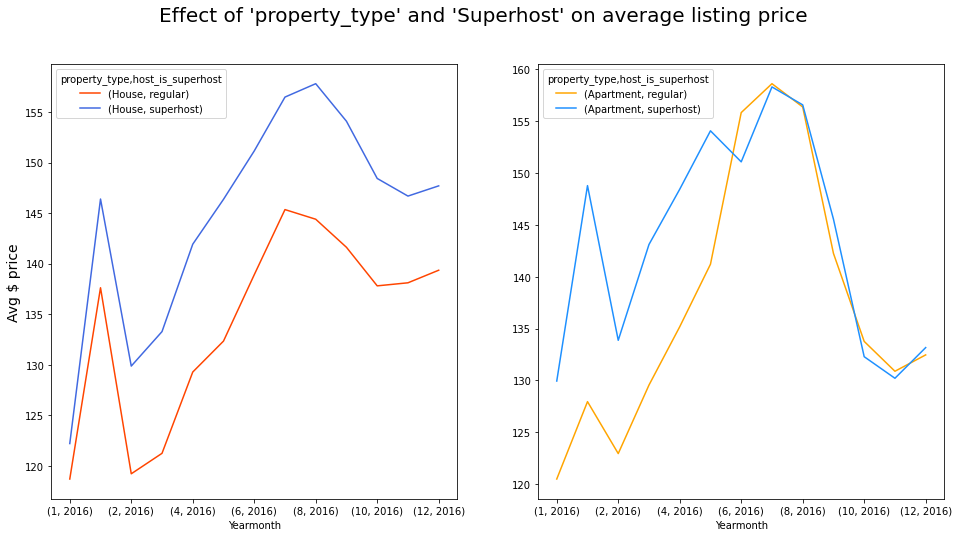

In [13]:
f, ax = plt.subplots(1, 2, figsize = (16, 8))
value_listings_db[value_listings_db['property_type'].isin(['House'])].pivot_table(
    index=['month', 'year'], values='price',
    columns=['property_type', 'host_is_superhost'],
    aggfunc=np.mean).plot(ax=ax[0], color=['orangered','royalblue'])
value_listings_db[value_listings_db['property_type'].isin(['Apartment'])].pivot_table(
    index=['month', 'year'], values='price',
    columns=['property_type', 'host_is_superhost'],
    aggfunc=np.mean).plot(ax=ax[1], color=['orange','dodgerblue'])
plt.suptitle('Effect of \'property_type\' and \'Superhost\' on average listing price', size=20)
plt.setp(ax[[0,1]], xlabel='Yearmonth')
ax[0].set_ylabel('Avg $ price', size=14)
plt.show()

The following metric we have checked is the percentage of bookings over time. We are interested in seeing 
whether superhosts have higher listing booked percentage compared to regular hosts.

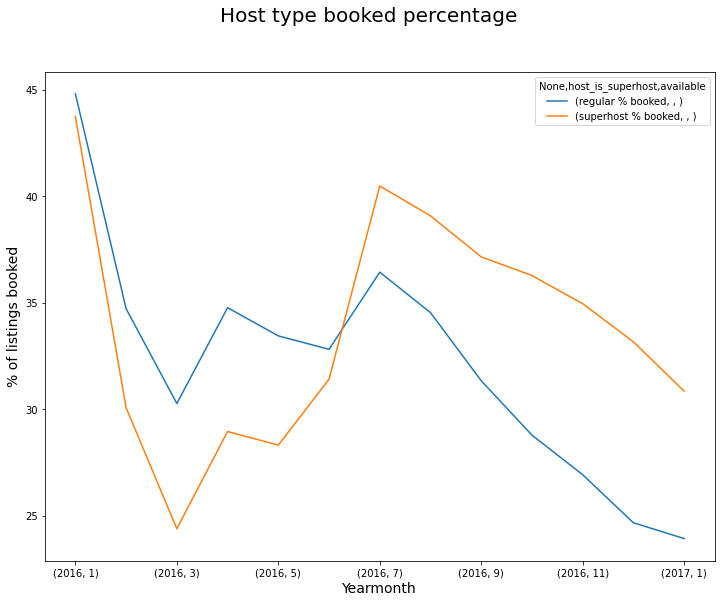

In [17]:
# check amount of booked dates per host type
def pct_of_booked(df):
    """
    Function calculates a pivot table containing % of booked listings for both types of hosts.
        * df: A pandas dataframe
    :return: A pandas pivot table
    """
    sh_available = df.pivot_table(
        columns=['host_is_superhost', 'available'], values='price', aggfunc=[len], index=['year', 'month']
    )
    
    sh_available['regular % booked'] = (sh_available.iloc[:, 0] / (
            sh_available.iloc[:, 0] + sh_available.iloc[:, 1])) * 100
    sh_available['superhost % booked'] = (sh_available.iloc[:, 2] / (
            sh_available.iloc[:, 2] + sh_available.iloc[:, 3])) * 100
    
    return sh_available

superhost_availability = pct_of_booked(seattle_df_clean)

f, ax = plt.subplots(1, 1, figsize = (12, 9))
superhost_availability.iloc[:, [4, 5]].plot(ax=ax)
plt.suptitle('Host type booked percentage', size=20)
plt.xlabel("Yearmonth", size=14)
plt.ylabel("% of listings booked", size=14)
plt.show()

We can observe a trend where the percent of booked properties rises through the winter holiday period, then 
drops for the remainder of winter and spring, and then rises again for the summer season. Although this is 
only a one year period we can see that **superhosts** have higher number of booked days in the second half 
of the year. 

We should also note that **superhosts** get booked earlier in advance, which we can observe from the chart 
as we move towards the end of the time series. The booked ratio for superhosts is higher than that of 
**regular** hosts.

### T-test

As a final point for this part of the analysis we have used an independent sample t-test to check for 
differences in the listing prices of regular and superhosts. The Independent Samples T-Test is a statistical 
test used to determine if 2 groups are significantly different from each other on your variable of interest. 
The variable of interest should be continuous, be normally distributed, and have a similar spread between your 
2 groups.

[]

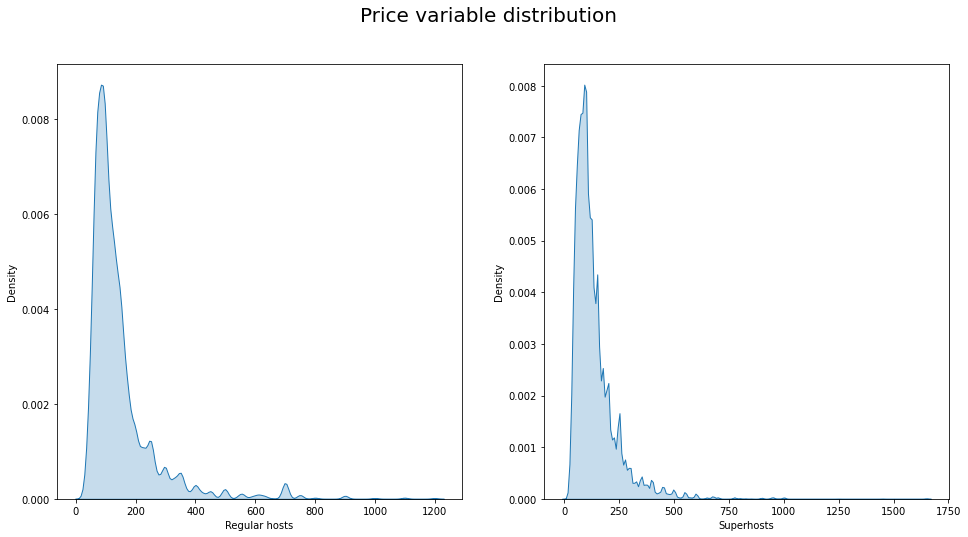

In [19]:
# independent sample t-test - compare the prices of superhosts vs. regular hosts
# check the distributions of samples
superhost = value_listings_db[value_listings_db['host_is_superhost'].isin(['superhost'])].price
regular_host = value_listings_db[value_listings_db['host_is_superhost'].isin(['regular'])].price

f, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
sns.kdeplot(superhost, shade=True, ax=axs[0])
sns.kdeplot(regular_host, shade=True, ax=axs[1])
plt.suptitle('Price variable distribution', size=20)
plt.setp(axs[[0]], xlabel='Regular hosts')
plt.setp(axs[[1]], xlabel='Superhosts')
ax.set_ylabel('Density')
plt.plot()

In [23]:
superhost.describe()

count    187614.000000
mean        146.851296
std         119.298576
min          29.000000
25%          80.000000
50%         110.000000
75%         161.000000
max        1199.000000
Name: price, dtype: float64


In [21]:
regular_host.describe()

count    746836.000000
mean        135.711346
std         101.054909
min          10.000000
25%          75.000000
50%         105.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

We can see that the two variables approximately fit the conditions for the T-test. The results indicate 
that the means of the two samples are statistically different from each other.

In [24]:
t_test = sm.stats.ttest_ind(x1=superhost, x2=regular_host)
print('T-test results:\n\n\tTest statistic - ', t_test[0], '\n\tP-value - ', t_test[1], 
      '\n\tDegrees of freedom - ', t_test[2])

T-test results:

	Test statistic -  41.09368110092382 
	P-value -  0.0 
	Degrees of freedom -  934448.0


### Results of the analysis

In this analysis we have looked at Airbnb Superhosts and tried to determine whether there is any advantage to 
having that status. Several viewpoints have been analyzed in order to reach a definite conclusion. The overall
 answer appears to be **YES**. Superhosts enjoy a variety of benefits in terms of their listings, from higher
daily listing prices to higher number of booked days and more.

This has been confirmed by the use of independent samples t-test, a statistical tool for analyzing two sample
means. We have checked to see if mean daily price of listings for superhosts and regular hosts are the same 
and they have proven not to be.

This means that there is clearly a benefit to having a Superhost status, not least from the increased revenue, 
but also from more booked day, better visibility on the website, etc.

